In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [3]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

### Campaign structure 

### 2. Calculate scattering

In [4]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [5]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [6]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

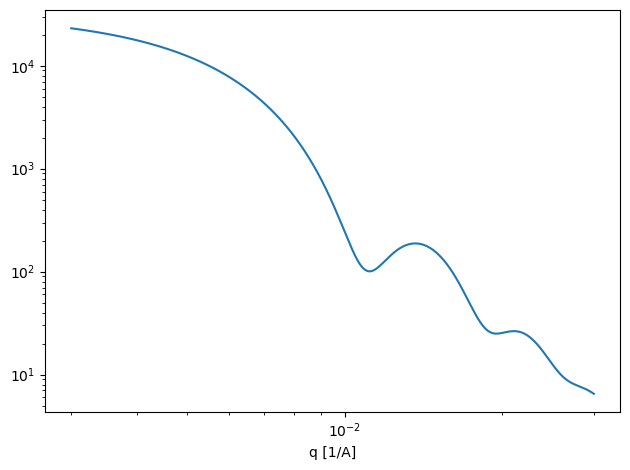

In [7]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [21]:
trials = {'baseline':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'noise_1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'as_run_now':{
        'batch_size':10,
        'amplitude_weight':0.5,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'DLS':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'DLS',
        'pdi_weight':0.5,
        'distance':'apdist'
        },
     'rmse':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'rmse'
        },
     'batch_size_10':{
        'batch_size':10,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'restricted_bounds':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.06, 0.08, 0.08], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
    'SobolBaseline':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
    }

In [30]:
trials_3 = {'DLS_pdipoint1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'DLS',
        'pdi_weight':0.1,
        'distance':'apdist'
        },
}


In [34]:
budget = 20

for trial_name, params in trials_3.items():
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']
    characterization = params['characterization']
    distance = params.get('distance', None)
    pdi_weight = params.get('pdi_weight', None)

    target_d = target_r_nm*2

    if trial_name in ['baseline', 'noise_1', 'as_run_now', 'DLS']:
        continue

    print(distance)

    execute.run_grouped_trials(target_I, q_grid, batch_size, amplitude_weight, m_samples, lower_bounds, upper_bounds, trial_name, noise_level, budget, target_d, target_pdi, characterization = characterization, distance_metric = distance, pdi_weight = pdi_weight)

apdist
Running optimization for trial DLS_pdipoint1
### Replicate 0 ###
starting initial samples
batch distance metric:  apdist
starting batch 1
Optimized acqf in 0.9423158168792725 s
batch distance metric:  apdist
starting batch 2
Optimized acqf in 6.65263295173645 s
batch distance metric:  apdist
starting batch 3
Optimized acqf in 20.84101366996765 s
batch distance metric:  apdist
starting batch 4
Optimized acqf in 50.58922863006592 s
batch distance metric:  apdist
### Replicate 1 ###
starting initial samples
batch distance metric:  apdist
starting batch 1
Optimized acqf in 0.405498743057251 s
batch distance metric:  apdist
starting batch 2
Optimized acqf in 4.688946008682251 s
batch distance metric:  apdist
starting batch 3
Optimized acqf in 50.127326011657715 s
batch distance metric:  apdist
starting batch 4
Optimized acqf in 7.013935089111328 s
batch distance metric:  apdist
### Replicate 2 ###
starting initial samples
batch distance metric:  apdist
starting batch 1
Optimized acqf